In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

#### Sección a) En esta parte se procede a cargar los datos time_series_data.csv con cual se trabajara en esta parte. Primero se procede a procesar estos datos por un escalado y luego a partir del dataset escalado se particiona en 1500 para filas(datos) entrenamiento y 500 para pruebas.

In [2]:
name_f = "time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values

print (dataframe.describe())
print (dataframe.shape)
total = 2000
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print ("Son %d datos de entrenamiento, correspondiente al %f por ciento de los datos"%(n_train,100*n_train/total))
print ("Son %d datos de pruebas, correspondiente al %f por ciento de los datos"%(n_test,100*n_test/total))

       Daily minimum temperatures in Melbourne, Australia, 1981-1990
count                                        2000.000000            
mean                                           11.148250            
std                                             4.194983            
min                                             0.000000            
25%                                             8.100000            
50%                                            11.000000            
75%                                            14.000000            
max                                            26.299999            
(2000, 1)
Son 1500 datos de entrenamiento, correspondiente al 75.000000 por ciento de los datos
Son 500 datos de pruebas, correspondiente al 25.000000 por ciento de los datos


In [3]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)


stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
print ("El valor mínimo es : ", np.min(stream_train_scaled))
print ("El valor máximo es : ",np.max(stream_train_scaled))

El valor mínimo es :  0.0
El valor máximo es :  1.0


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

#### Sección b) En esta parte veremos la definición de lag, la cual es el numero de periodos los cuales seran usado para producir la predicción. Para ello usaremos la función que recibe una secuencia de valores y retorna una matriz con los respectivos arreglos de lag y su output.

In [4]:
stream_train_scaled.shape

(1500, 1)

In [5]:
def create_dataset(dataset,lag =1): 
    #preprocesamiento asumiendo dataset es un arreglo en secuencia
    #por ex 20.7,17.9,18.8,14.6,15.8,15.8,10.1
    dataX = []
    dataY =[]
    for t in range(lag,len(dataset)):
        #Se extrae el primer valor y se designa como el valor a predecir (Y)
        Y = dataset[t]
        #dataY.append(Y)
        dataY+= list(Y) 
        
        #se crea el conjunto X (inputs) para predecir Y
        # que corresponden a los i-lag valores
        X_ = []
        #se recorre los i valores anteriores a Y
        for i in np.arange(lag,0,-1):
            X_ += list( dataset[t-i] )
        dataX.append(X_)
    #No es necesario crear una matriz dado a que más adelante se
    #pide en el formato trainX,trainY = create_database
    return np.array(dataX),np.array(dataY)
#DB = [[20.7],[17.9],[18.8],[14.6],[15.8],[15.8],[10.1]]
#print(DB)
#x = create_dataset(DB,3)
#print(x)

#### Sección c) Ahora usando la función definida anteriormente se generara un conjunto de entrenamiento y prueba.

In [6]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

In [7]:
print(testX.shape)
print(trainX)
print(trainX.shape)

(497, 3)
[[ 0.7870723   0.68060839  0.71482891]
 [ 0.68060839  0.71482891  0.5551331 ]
 [ 0.71482891  0.5551331   0.60076052]
 ..., 
 [ 0.72243351  0.59695822  0.68441069]
 [ 0.59695822  0.68441069  0.5627377 ]
 [ 0.68441069  0.5627377   0.52851713]]
(1497, 3)


In [8]:
print(trainY)

[ 0.5551331   0.60076052  0.60076052 ...,  0.5627377   0.52851713
  0.49429661]


#### Sección d) Se tienen los datos de forma [sample, features] despues de pasar por c), pero para poder utilizarlos en la red LSTM se necesita que estos datos sean de la forma [sample, time steps,features]. Por lo que se aplica una transformación que logre el objetivo deseado.

In [9]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [10]:
print(trainX)
print(trainX.shape)

[[[ 0.7870723   0.68060839  0.71482891]]

 [[ 0.68060839  0.71482891  0.5551331 ]]

 [[ 0.71482891  0.5551331   0.60076052]]

 ..., 
 [[ 0.72243351  0.59695822  0.68441069]]

 [[ 0.59695822  0.68441069  0.5627377 ]]

 [[ 0.68441069  0.5627377   0.52851713]]]
(1497, 1, 3)


In [11]:
testX = np.reshape(testX, (testX.shape[0],1 ,testX.shape[1]))

In [12]:
print(testX.shape)

(497, 1, 3)


#### Sección e) Teniendo ya nuestros datos, se procede al entrenamiento de la red LSTM con un lag de valor 3.

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import time

model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo en entrenar: %f'%(time.time() - start_time ))

Using TensorFlow backend.
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 3), recurrent_activation="sigmoid")`
  import sys


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/25
1497/1497 [==============================] - 9s 6ms/step - loss: 0.0302
Epoch 2/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0116
Epoch 3/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0109
Epoch 4/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0106
Epoch 5/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0105
Epoch 6/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0103
Epoch 7/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0102
Epoch 8/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0103
Epoch 9/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0102
Epoch 10/25
1497/1497 [==============================] - 5s 4ms/step - loss: 0.0101
Epoch 11/25
1497/1497 [

#### Sección f) Una vez finalizado el entrenamiento de la red, se procede a la predicción, para el conjunto de entrenamiento y el conjunto de pruebas. Y se impone que los valores sean desnormalizados para el calculo del error.

In [84]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])

testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

ValueError: Error when checking : expected lstm_1_input to have shape (None, None, 3) but got array with shape (1497, 3, 1)

#### Sección g) Se computa el error, de tipo RMSE en este caso que el output no es una clasificación, sobre el entrenamiento y prueba. Agregar comentarios de lo encontrado. Probar con otra medida de error como MSE

In [85]:
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE


#### Sección h) Ahora se grafican las predicciones obtenidas con los datos originales. Para analizar el contraste, además se pide un extrato para notar el detalle de como es la predicción

In [86]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict


<IPython.core.display.Javascript object>


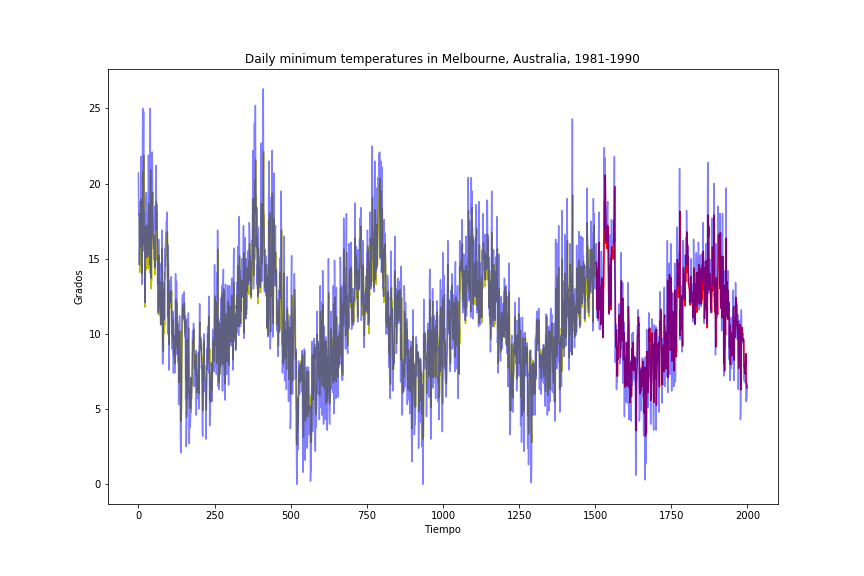

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(trainPredictPlot,'y', label= "Entrenamiento Predecido",alpha=1)
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido",alpha=1)
plt.plot(dataframe.values,'b', label = "Dataset Real",alpha=0.5)

plt.ylabel("Grados")
plt.xlabel("Tiempo")
plt.title("Daily minimum temperatures in Melbourne, Australia, 1981-1990")
plt.show()

#### Sección i) Ahora se intenta mejorar los resultados, para ello se entrena con un timestep de 3. Para comparar se observan los errores de entrenamiento y prueba. Además se mide los tiempos de ejecución del entrenamiento.

In [47]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [48]:
model2 = Sequential()
model2.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model2.add(Dense(1,activation='linear'))
model2.compile(loss='mean_squared_error', optimizer='adam')
start_time = time.time()
model2.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo en entrenar: %f'%(time.time() - start_time ))

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
  


Epoch 1/25
1497/1497 [==============================] - 8s 5ms/step - loss: 0.0279
Epoch 2/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0132
Epoch 3/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0126
Epoch 4/25
1497/1497 [==============================] - 8s 5ms/step - loss: 0.0123
Epoch 5/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0120
Epoch 6/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0116
Epoch 7/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0114
Epoch 8/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0113
Epoch 9/25
1497/1497 [==============================] - 8s 5ms/step - loss: 0.0110
Epoch 10/25
1497/1497 [==============================] - 8s 5ms/step - loss: 0.0108
Epoch 11/25
1497/1497 [==============================] - 7s 5ms/step - loss: 0.0108
Epoch 12/25
1497/1497 [==============================] - 8s 5ms/step - loss: 0.0107
E

In [49]:
trainPredict = model2.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])

testPredict = model2.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

In [50]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY_[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.43 RMSE


In [53]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict


In [80]:
from importlib import reload
reload(plt)
%matplotlib notebook

<IPython.core.display.Javascript object>


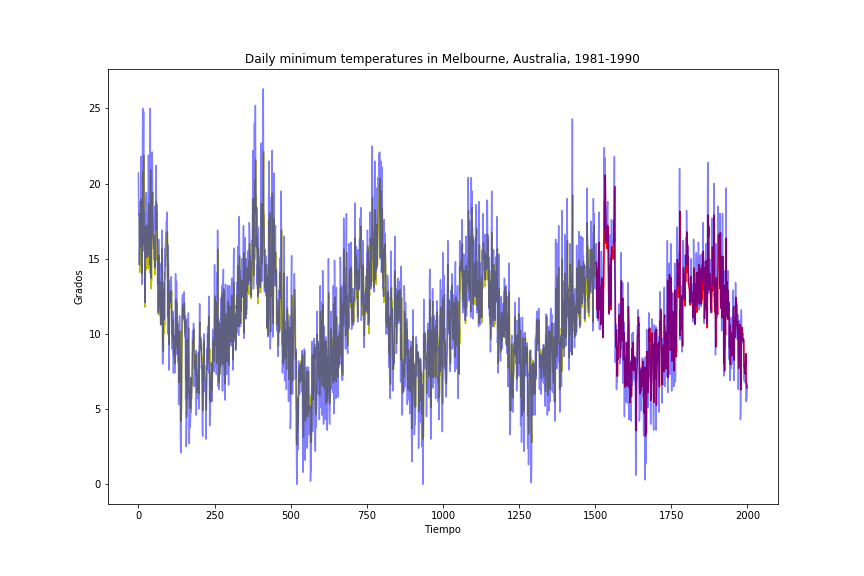

In [83]:
plt.close()
plt.figure(figsize=(12,8))
plt.plot(trainPredictPlot,'y', label= "Entrenamiento Predecido",alpha=1)
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido",alpha=1)
plt.plot(dataframe.values,'b', label = "Dataset Real",alpha=0.5)

plt.ylabel("Grados")
plt.xlabel("Tiempo")
plt.title("Daily minimum temperatures in Melbourne, Australia, 1981-1990")
plt.show()

#### Sección j) Ahora se fija un valor para LSTM, para el modelo, además se usa 5-fold cross validation, para el entrenamiento. Además como experimento se utiliza un conjunto de validación que corresponde a datos entre las filas 2000 a 2500.

### Sección k) Se compara el rendimiento con un lag en el rango 1 a 4 (1,2,3,4).

### Sección l) Usando un lag de 3. se compara el modelo con LSTM a un RNN simple y una GRU. Se comparan en tiempo de entrenamiento y convergencia.

### Sección m) Se entre un modelo LSTM con batches. Y se compara con las predicción anteriores.

### Sección n) Se juega con el tamaño del batch para determinar la influencia de este.

### Sección o) Construir una LSTM apilada, y compárela con lo obtenido en la parte i).